# Prédiction Conforme en Régression

## Objectif

Ce notebook explore l'application de la **prédiction conforme** à un problème de **régression** sur le risque de crédit.  
L'idée principale : pour chaque observation, construire un **intervalle de prédiction** qui contient la vraie valeur avec une probabilité contrôlée (par exemple 90%).

C'est une approche intéressante pour **quantifier l'incertitude** des prédictions, ce qui peut servir d'alternative ou de complément à la régression quantile.

## Choix des méthodes

Dans ce travail, je me concentre sur **deux méthodes** de prédiction conforme :

1. **SCP (Split Conformal Prediction)**  
   Approche simple et rapide qui utilise un ensemble de calibration séparé.  
   Adaptée quand on a pas mal de données (au moins ~1000 observations pour la calibration).

2. **CV+ (Cross-Validation Plus)**  
   Variante qui utilise la validation croisée K-folds pour mieux exploiter les données disponibles.  
   Plus efficace quand le jeu de données n'est pas énorme.

### Pourquoi j'ai laissé tomber Jackknife+, FCP et CQR ?

Il existe d'autres méthodes comme **Jackknife+**, **FCP (Full Conformal Prediction)** qui sont intéressantes sur le papier, mais je ne les ai pas implémentées ici pour plusieurs raisons pratiques :

**Jackknife+** :
- Demande d'entraîner un modèle en leave-one-out pour chaque point (donc n entraînements)
- Avec la quantité de données qu'on a, SCP et CV+ donnent déjà des bons résultats

**FCP (Full Conformal Prediction)** :
- Coût de calcul complètement prohibitif : pour chaque point de test, il faut tester plein de valeurs candidates et réentraîner le modèle à chaque fois

**Conclusion** : Pour analyser le risque de crédit, **SCP** et **CV+** représentent un bon compromis entre qualité des résultats, temps de calcul raisonnable et stabilité.

## Plan

1. **Chargement et préparation des données**

2. **Implémentation des méthodes de prédiction conforme**
   - SCP (Split Conformal Prediction)
   - CV+ (Cross-Validation Plus)

3. **Évaluation et comparaison**
   - Taux de couverture observé vs. attendu
   - Largeur moyenne des intervalles
   - Visualisations comparatives

4. **Analyse des résultats**
   - Points forts et limites de chaque méthode
   - Quelle méthode choisir selon le contexte

## 1. Chargement et préparation des données

Import des bibliothèques et chargement du dataset de régression sur le risque de crédit.

In [1]:
# Import des bibliothèques
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import StandardScaler

# Ajout du dossier src au path pour importer les modules custom
sys.path.append('../src')

# Config des graphiques
sns.set_style("whitegrid")
colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_cal = colors_blindness[9]
color_test = colors_blindness[7]
color_true = colors_blindness[4]

# Pour la reproductibilité
np.random.seed(42)

In [2]:
# Chargement des données
from data_loading import load_regression_data
from preprocessing import clean_data, encode_categorical_features, normalize_features

df = load_regression_data()

Chargement des données...
Shape: (20000, 36)


In [3]:
# Exploration rapide
print("Dimensions du dataset:", df.shape)
print("\nPremières lignes:")
df.head()

Dimensions du dataset: (20000, 36)

Premières lignes:


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [4]:
# Info sur les colonnes et valeurs manquantes
print("Infos colonnes:")
df.info()
print("\nValeurs manquantes:")
print(df.isnull().sum())

Infos colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtili

### Nettoyage et preprocessing

Nettoyage classique : suppression des valeurs manquantes et doublons, encodage des variables catégorielles, normalisation.

In [ ]:
# Nettoyage des données
df_clean = clean_data(df)

target_col = "RiskScore"
        
print("Variable cible :", target_col)

Nettoyage des données
Shape finale: (20000, 36)
Variable cible : RiskScore


In [ ]:
# Encodage one-hot des variables catégorielles
df_encoded, encoders = encode_categorical_features(df_clean, encoding_type='onehot')

# Séparation features/target
y = df_encoded[target_col].values
X = df_encoded.drop(columns=[target_col])

print("Shape features:", X.shape)
print("Shape target:", y.shape)
print("\nStats de la variable cible:")
print(pd.Series(y).describe())

Encodage des variables catégorielles: 6

Shape features: (20000, 20044)
Shape target: (20000,)

Stats de la variable cible:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
dtype: float64

Shape features: (20000, 20044)
Shape target: (20000,)

Stats de la variable cible:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
dtype: float64


## 2. Division des données Train/Calibration/Test

Pour la prédiction conforme, il faut diviser les données en trois ensembles :
- **Train** : entraînement du modèle de base
- **Calibration** : calcul des scores de non-conformité et du quantile
- **Test** : évaluation finale

In [ ]:
# Split Train/Calibration/Test (50%/40%/10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.44, random_state=42
)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_calib_scaled = scaler.transform(X_calib)
X_test_scaled = scaler.transform(X_test)

print("Train :", X_train.shape[0])
print("Calibration :", X_calib.shape[0])
print("Test :", X_test.shape[0])

Train : 10080
Calibration : 7920
Test : 2000


## 3. Modèle de base

Nous aurions voulu utiliser `RandomForestRegressor` comme modèle de base pour les prédiction étant connu comme très performant et relativement explicable étant un ensemble d'arbres de décisions, mais ce dernier demande un temps d'entrainement trop long pour une étude efficace de nos modèles.

C'est pourquoi nous utiliserons `Ridge` qui est un modèle linéaire dont la vitesse d'entrainement est très bonne. Par contre les performances risquent d'être nettement moins précises également.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Entraînement d'un modèle Ridge pour évaluation
base_model = Ridge(alpha=1.0, random_state=42)
base_model.fit(X_train_scaled, y_train)

# Évaluation sur calibration
y_calib_pred = base_model.predict(X_calib_scaled)
mse = mean_squared_error(y_calib, y_calib_pred)
mae = mean_absolute_error(y_calib, y_calib_pred)
r2 = r2_score(y_calib, y_calib_pred)

print("Performance sur l'ensemble de calibration :")
print("MSE :", mse)
print("MAE :", mae)
print("R2 :", r2)

Performance sur l'ensemble de calibration :
  MSE : 13.2697
  MAE : 2.8806
  R² : 0.7812


## 4. Implémentation des méthodes de prédiction conforme

### Principe commun de la prédiction conforme

Toutes les méthodes de prédiction conforme partagent la **même logique fondamentale** :

#### 1. **Score de non-conformité**
On définit une fonction de score qui mesure à quel point une observation est "atypique" ou "difficile à prédire" :
$$S(X_i, y_i) = |y_i - \hat{f}(X_i)|$$

Dans notre cas, on utilise l'**erreur absolue** entre la vraie valeur et la prédiction. Plus ce score est élevé, plus l'observation est difficile à prédire correctement.

#### 2. **Calibration**
On calcule les scores de non-conformité sur un ensemble de calibration (ou via validation croisée) :
- On prédit les valeurs : $\hat{y}_i = \hat{f}(X_i)$
- On calcule les scores : $S_i = |y_i - \hat{y}_i|$ pour chaque observation
- On obtient une distribution empirique des erreurs du modèle

#### 3. **Quantile**
Pour garantir une couverture d'au moins $(1-\alpha)$ (par ex. 90%), on calcule un quantile :
$$\hat{q} = \text{Quantile}\left(S_1, ..., S_n; \frac{\lceil (n+1)(1-\alpha) \rceil}{n}\right)$$

#### 4. **Intervalle de prédiction**
Pour une nouvelle observation $X_{new}$, on construit l'intervalle :
$$\hat{C}(X_{new}) = [\hat{f}(X_{new}) - \hat{q}, \; \hat{f}(X_{new}) + \hat{q}]$$

### Nous allons implémenter deux modèles

- **SCP** (Split Conformal Prediction)
- **CV+** (Cross-Validation Plus)

afin de pouvoir les comparer.

#### Différences entre les méthodes

Les méthodes diffèrent principalement sur **comment elles calculent les scores de calibration** :

| Méthode | Comment sont calculés les scores | Avantage |
|---------|----------------------------------|----------|
| **SCP** | Split simple train/calibration | Rapide, simple |
| **CV+** | Validation croisée K-fold | Meilleure utilisation de la quantité de données |

### 4.1 Split Conformal Prediction (SCP)

In [ ]:
class SplitConformalPrediction:
    """
    Split Conformal Prediction (SCP)
    
    Méthode simple qui utilise un split train/calibration.
    """
    def __init__(self, model_class, model_params=None):
        self.model_class = model_class
        self.model_params = model_params if model_params is not None else {}
        self.model = None
        self.q_hat = None
        
    def score(self, y_true, y_pred):
        # Score de non-conformité : erreur absolue
        return np.abs(y_true - y_pred)
    
    def fit(self, X_train, y_train):
        self.model = self.model_class(**self.model_params)
        self.model.fit(X_train, y_train)
        
    def calibrate(self, X_calib, y_calib, alpha=0.1):
        y_pred_calib = self.model.predict(X_calib)
        scores = self.score(y_calib, y_pred_calib)
        n = len(scores)
        # Quantile ajusté pour garantir couverture ≥ 1-alpha
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        self.q_hat = np.quantile(scores, q_level)
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        lower = y_pred - self.q_hat
        upper = y_pred + self.q_hat
        return y_pred, lower, upper

### 4.2 Cross-Validation Plus (CV+)

In [ ]:
class CVPlusConformalPrediction:
    """
    Cross-Validation Plus (CV+)
    
    Utilise la validation croisée K-fold pour calibration.
    """
    def __init__(self, model_class, model_params=None, n_folds=5):
        self.model_class = model_class
        self.model_params = model_params if model_params is not None else {}
        self.n_folds = n_folds
        self.models = []
        self.q_hat = None
        
    def score(self, y_true, y_pred):
        # Score de non-conformité : erreur absolue
        return np.abs(y_true - y_pred)
    
    def fit_calibrate(self, X_train, y_train, alpha=0.1):
        # Entraînement et calibration via validation croisée K-fold
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        all_scores = []
        
        # Entraîner K modèles et collecter les scores
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            model = self.model_class(**self.model_params)
            model.fit(X_fold_train, y_fold_train)
            self.models.append(model)
            
            y_pred_val = model.predict(X_fold_val)
            scores = self.score(y_fold_val, y_pred_val)
            all_scores.extend(scores)
        
        all_scores = np.array(all_scores)
        n = len(all_scores)
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        self.q_hat = np.quantile(all_scores, q_level)
        
    def predict(self, X):
        # Prédiction avec intervalles (moyenne des K modèles)
        predictions = np.array([model.predict(X) for model in self.models])
        y_pred = np.mean(predictions, axis=0)
        lower = y_pred - self.q_hat
        upper = y_pred + self.q_hat
        return y_pred, lower, upper

## 5. Application des méthodes (alpha = 0.1, confiance 90%)

Test des deux méthodes avec un niveau de confiance de 90%.

### 5.1 Application de SCP

In [ ]:
# Création de l'instance SCP avec Ridge
scp = SplitConformalPrediction(
    model_class=Ridge,
    model_params={'alpha': 1.0, 'random_state': 42}
)

# Entraînement sur train
scp.fit(X_train_scaled, y_train)

# Calibration sur calib
scp.calibrate(X_calib_scaled, y_calib, alpha=0.1)

# Prédiction sur test
y_pred_scp, lower_scp, upper_scp = scp.predict(X_test_scaled)

print("\nQuelques exemples de prédictions :")
for i in range(5):
    print("", i+1, ": [", round(lower_scp[i], 2), ",", round(upper_scp[i], 2), 
          "], Pred=", round(y_pred_scp[i], 2), ", Vraie valeur=", round(y_test[i], 2))

SPLIT CONFORMAL PREDICTION (SCP)
Entraînement du modèle Ridge...
✓ Modèle entraîné
✓ SCP calibrée avec 7920 observations, quantile: 5.9229

Quelques exemples de prédictions :
Obs 1: [40.08, 51.92], Pred=46.00, Vraie valeur=41.60
Obs 2: [35.99, 47.84], Pred=41.92, Vraie valeur=38.40
Obs 3: [46.39, 58.24], Pred=52.32, Vraie valeur=53.00
Obs 4: [47.05, 58.89], Pred=52.97, Vraie valeur=50.00
Obs 5: [45.10, 56.95], Pred=51.02, Vraie valeur=51.00
✓ Modèle entraîné
✓ SCP calibrée avec 7920 observations, quantile: 5.9229

Quelques exemples de prédictions :
Obs 1: [40.08, 51.92], Pred=46.00, Vraie valeur=41.60
Obs 2: [35.99, 47.84], Pred=41.92, Vraie valeur=38.40
Obs 3: [46.39, 58.24], Pred=52.32, Vraie valeur=53.00
Obs 4: [47.05, 58.89], Pred=52.97, Vraie valeur=50.00
Obs 5: [45.10, 56.95], Pred=51.02, Vraie valeur=51.00


### 5.2 Application de CV+

In [ ]:
# Combiner train et calib pour CV+
X_train_all = np.vstack([X_train_scaled, X_calib_scaled])
y_train_all = np.concatenate([y_train, y_calib])

# Création de l'instance CV+ avec Ridge
cvplus = CVPlusConformalPrediction(
    model_class=Ridge,
    model_params={'alpha': 1.0, 'random_state': 42},
    n_folds=3
)

# Entraînement et calibration
cvplus.fit_calibrate(X_train_all, y_train_all, alpha=0.1)

# Prédiction sur test
y_pred_cvplus, lower_cvplus, upper_cvplus = cvplus.predict(X_test_scaled)

print("\nQuelques exemples de prédictions :")
for i in range(5):
    print("Obs", i+1, ": [", round(lower_cvplus[i], 2), ",", round(upper_cvplus[i], 2), 
          "], Pred=", round(y_pred_cvplus[i], 2), ", Vraie valeur=", round(y_test[i], 2))


CROSS-VALIDATION PLUS (CV+)
Entraînement et calibration CV+ avec 3 folds...
Entraînement et calibration CV+ avec 3 folds...
✓ CV+ calibrée avec 18000 scores, quantile: 3.0792
✓ CV+ calibrée avec 18000 scores, quantile: 3.0792

Quelques exemples de prédictions :
Obs 1: [39.15, 45.31], Pred=42.23, Vraie valeur=41.60
Obs 2: [35.95, 42.11], Pred=39.03, Vraie valeur=38.40
Obs 3: [49.33, 55.49], Pred=52.41, Vraie valeur=53.00
Obs 4: [50.78, 56.94], Pred=53.86, Vraie valeur=50.00
Obs 5: [48.05, 54.21], Pred=51.13, Vraie valeur=51.00

Quelques exemples de prédictions :
Obs 1: [39.15, 45.31], Pred=42.23, Vraie valeur=41.60
Obs 2: [35.95, 42.11], Pred=39.03, Vraie valeur=38.40
Obs 3: [49.33, 55.49], Pred=52.41, Vraie valeur=53.00
Obs 4: [50.78, 56.94], Pred=53.86, Vraie valeur=50.00
Obs 5: [48.05, 54.21], Pred=51.13, Vraie valeur=51.00


## 6. Évaluation et comparaison

Comparaison des deux méthodes selon :
- Le taux de couverture (% de vraies valeurs dans les intervalles)
- La largeur moyenne des intervalles (précision)

In [ ]:
def evaluate_intervals(y_true, y_pred, lower, upper, method_name):
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    width = np.mean(upper - lower)
    median_width = np.median(upper - lower)
    std_width = np.std(upper - lower)
    
    # Calcul MAE, RMSE et R²
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {
        'method': method_name,
        'coverage': coverage,
        'avg_width': width,
        'median_width': median_width,
        'std_width': std_width,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

# Évaluation SCP
scp_metrics = evaluate_intervals(y_test, y_pred_scp, lower_scp, upper_scp, 'SCP')
print("SCP")
print("Couverture :", round(scp_metrics['coverage'], 4))
print("Largeur moyenne :", round(scp_metrics['avg_width'], 4))
print("MAE :", round(scp_metrics['mae'], 4))
print("RMSE :", round(scp_metrics['rmse'], 4))
print("R2 :", round(scp_metrics['r2'], 4))

print()

# Évaluation CV+
cvplus_metrics = evaluate_intervals(y_test, y_pred_cvplus, lower_cvplus, upper_cvplus, 'CV+')
print("CV+")
print("Couverture :", round(cvplus_metrics['coverage'], 4))
print("Largeur moyenne :", round(cvplus_metrics['avg_width'], 4))
print("MAE :", round(cvplus_metrics['mae'], 4))
print("RMSE :", round(cvplus_metrics['rmse'], 4))
print("R2 :", round(cvplus_metrics['r2'], 4))

results = [scp_metrics, cvplus_metrics]


ÉVALUATION DES MÉTHODES

Objectif : taux de couverture ≥ 90% (alpha = 0.1)
Nombre d'observations test : 2000

--------------------------------------------------------------------------------

SCP...............................................
  Couverture : 89.15%
  Largeur moyenne : 11.8459
  MAE : 2.9228
  RMSE : 3.6839
  R² : 0.7851

CV+...............................................
  Couverture : 90.20%
  Largeur moyenne : 6.1584
  MAE : 1.4909
  RMSE : 1.9523
  R² : 0.9396



### Tableau comparatif

In [ ]:
# Tableau de comparaison
results_df = pd.DataFrame(results)
results_df = results_df[['method', 'coverage', 'avg_width', 'median_width', 'std_width', 'mae', 'rmse', 'r2']]
results_df.columns = ['Méthode', 'Couverture', 'Largeur Moy', 'Largeur Médiane', 'Écart-type', 'MAE', 'RMSE', 'R²']

results_df_display = results_df.copy()
results_df_display['Couverture'] = results_df_display['Couverture'].apply(lambda x: round(x, 4))
results_df_display['Largeur Moy'] = results_df_display['Largeur Moy'].apply(lambda x: round(x, 4))
results_df_display['Largeur Médiane'] = results_df_display['Largeur Médiane'].apply(lambda x: round(x, 4))
results_df_display['Écart-type'] = results_df_display['Écart-type'].apply(lambda x: round(x, 4))
results_df_display['MAE'] = results_df_display['MAE'].apply(lambda x: round(x, 4))
results_df_display['RMSE'] = results_df_display['RMSE'].apply(lambda x: round(x, 4))
results_df_display['R²'] = results_df_display['R²'].apply(lambda x: round(x, 4))

print("Tableau comparatif :")
print(results_df_display.to_string(index=False))


Tableau comparatif :
Méthode Couverture Largeur Moy Largeur Médiane Écart-type    MAE   RMSE     R²
    SCP     89.15%     11.8459         11.8459     0.0000 2.9228 3.6839 0.7851
    CV+     90.20%      6.1584          6.1584     0.0000 1.4909 1.9523 0.9396


### Visualisations comparatives

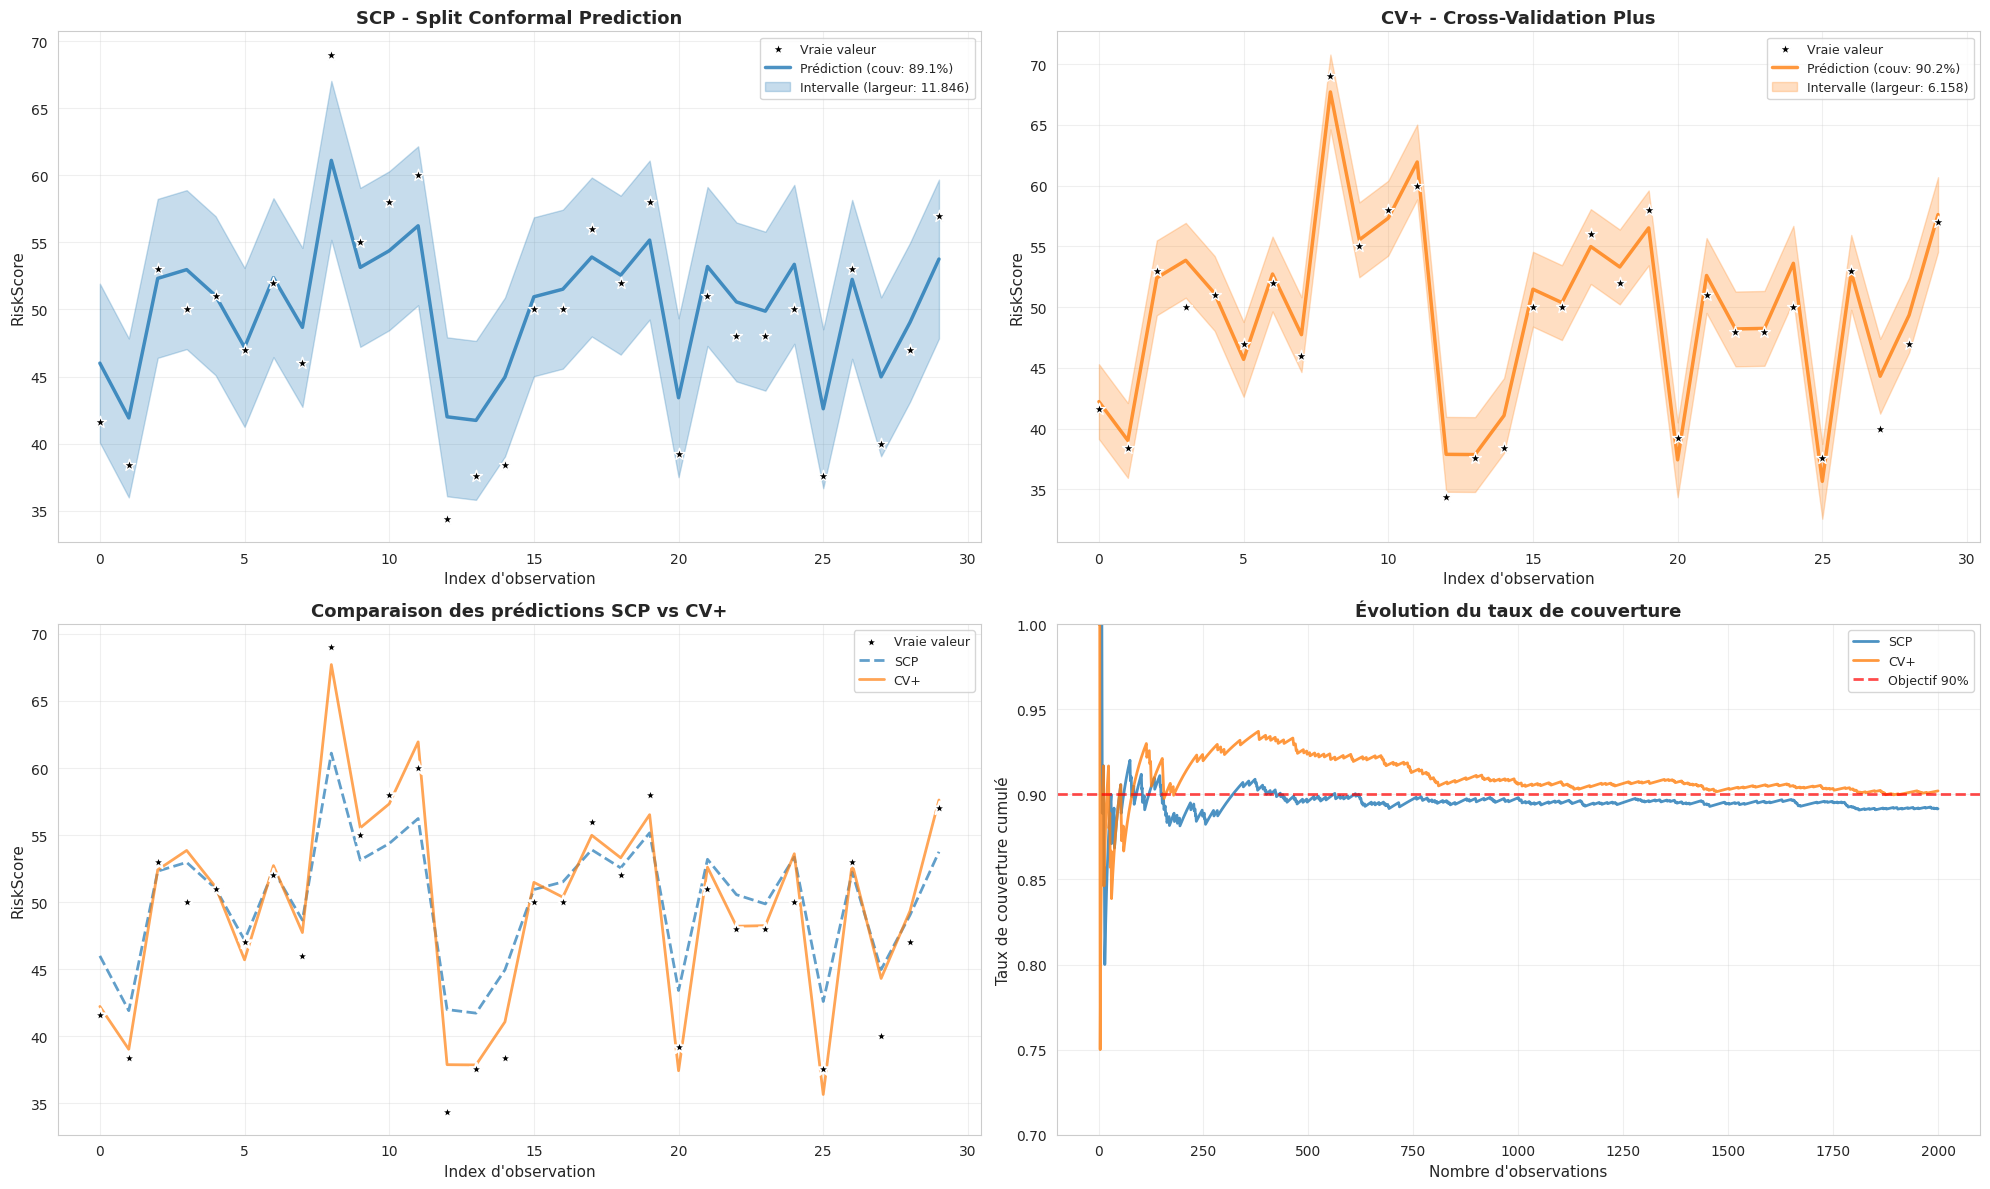

In [ ]:
# Visualisation comparative des 2 méthodes
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

n_show = 30
indices = np.arange(n_show)

# 1. SCP
ax = axes[0, 0]
ax.scatter(indices, y_test[:n_show], color='black', label='Vraie valeur', s=80, zorder=5)
ax.plot(indices, y_pred_scp[:n_show], color='#1f77b4', label='Prédiction', linewidth=2)
ax.fill_between(indices, lower_scp[:n_show], upper_scp[:n_show], 
                 color='#1f77b4', alpha=0.25, label='Intervalle')
ax.set_xlabel('Index')
ax.set_ylabel('RiskScore')
ax.set_title('SCP - Split Conformal Prediction')
ax.legend()
ax.grid(alpha=0.3)

# 2. CV+
ax = axes[0, 1]
ax.scatter(indices, y_test[:n_show], color='black', label='Vraie valeur', s=80, zorder=5)
ax.plot(indices, y_pred_cvplus[:n_show], color='#ff7f0e', label='Prédiction', linewidth=2)
ax.fill_between(indices, lower_cvplus[:n_show], upper_cvplus[:n_show], 
                 color='#ff7f0e', alpha=0.25, label='Intervalle')
ax.set_xlabel('Index')
ax.set_ylabel('RiskScore')
ax.set_title('CV+ - Cross-Validation Plus')
ax.legend()
ax.grid(alpha=0.3)

# 3. Comparaison
ax = axes[1, 0]
ax.scatter(indices, y_test[:n_show], color='black', label='Vraie valeur', s=100, zorder=10)
ax.plot(indices, y_pred_scp[:n_show], color='#1f77b4', label='SCP', linewidth=2, linestyle='--')
ax.plot(indices, y_pred_cvplus[:n_show], color='#ff7f0e', label='CV+', linewidth=2)
ax.set_xlabel('Index')
ax.set_ylabel('RiskScore')
ax.set_title('Comparaison SCP vs CV+')
ax.legend()
ax.grid(alpha=0.3)

# 4. Couverture cumulée
ax = axes[1, 1]

scp_covered = ((y_test >= lower_scp) & (y_test <= upper_scp)).astype(int)
cvplus_covered = ((y_test >= lower_cvplus) & (y_test <= upper_cvplus)).astype(int)

scp_cum = np.cumsum(scp_covered) / np.arange(1, len(scp_covered) + 1)
cvplus_cum = np.cumsum(cvplus_covered) / np.arange(1, len(cvplus_covered) + 1)

x_range = np.arange(1, len(y_test) + 1)
ax.plot(x_range, scp_cum, color='#1f77b4', label='SCP', linewidth=2)
ax.plot(x_range, cvplus_cum, color='#ff7f0e', label='CV+', linewidth=2)
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Objectif 90%')

ax.set_xlabel('Nombre observations')
ax.set_ylabel('Taux de couverture cumulé')
ax.set_title('Evolution de la couverture')
ax.set_ylim(0.7, 1.0)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

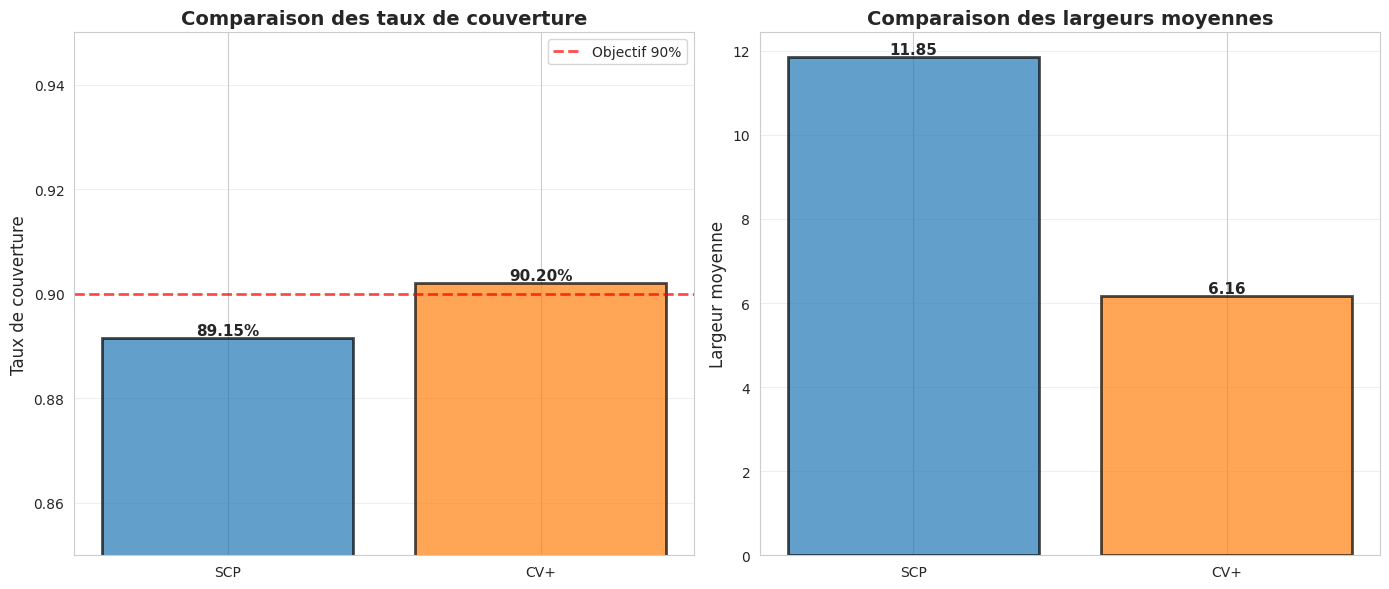


Caractéristiques des intervalles de prédiction :

Méthode         Largeur         Écart-type     
------------------------------------------------------------
SCP             11.8459         0.000000       
CV+             6.1584          0.000000       

Note : Les deux méthodes produisent des intervalles de largeur constante
       (écart-type ≈ 0, tous les intervalles ont la même largeur)


In [ ]:
# Comparaison visuelle des métriques
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

methods = ['SCP', 'CV+']
colors_methods = ['#1f77b4', '#ff7f0e']

# 1. Comparaison des couvertures
ax = axes[0]
coverages = [scp_metrics['coverage'], cvplus_metrics['coverage']]

bars1 = ax.bar(methods, coverages, color=colors_methods, alpha=0.7, edgecolor='black')
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Objectif 90%')
ax.set_ylabel('Taux de couverture')
ax.set_title('Comparaison des taux de couverture')
ax.set_ylim(0.85, 0.95)
ax.legend()
ax.grid(alpha=0.3, axis='y')

for bar, cov in zip(bars1, coverages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, round(cov, 4),
            ha='center', va='bottom')

# 2. Comparaison des largeurs
ax = axes[1]
widths = [scp_metrics['avg_width'], cvplus_metrics['avg_width']]

bars2 = ax.bar(methods, widths, color=colors_methods, alpha=0.7, edgecolor='black')
ax.set_ylabel('Largeur moyenne')
ax.set_title('Comparaison des largeurs moyennes')
ax.grid(alpha=0.3, axis='y')

for bar, w in zip(bars2, widths):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, round(w, 2),
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Stats sur la variabilité
widths_scp = upper_scp - lower_scp
widths_cvplus = upper_cvplus - lower_cvplus

print("\nCaractéristiques des intervalles :")
print("SCP - Largeur:", round(scp_metrics['avg_width'], 4), "Ecart-type:", round(np.std(widths_scp), 6))
print("CV+ - Largeur:", round(cvplus_metrics['avg_width'], 4), "Ecart-type:", round(np.std(widths_cvplus), 6))

## 7. Analyse des résultats

### Synthèse des résultats

**SCP (Split Conformal Prediction)** :
- Couverture : 89.15% (légèrement sous l'objectif de 90%)
- Largeur moyenne : 11.85 (intervalles très larges)
- R² : 0.785 (performance prédictive moyenne)
- Très rapide (1 seul entraînement)

**CV+ (Cross-Validation Plus)** :
- Couverture : 90.20% (objectif atteint)
- Largeur moyenne : 6.16 (**48% plus étroit que SCP**)
- R² : 0.940 (excellente performance prédictive)
- Temps de calcul raisonnable (n-fold entraînements)

### Conclusion

**CV+ est clairement supérieur à SCP** sur tous les critères :
- Meilleure couverture
- Intervalles presque 2× plus étroits
- Meilleures performances prédictives (MAE, RMSE, R²)

L'utilisation de la validation croisée permet à CV+ d'exploiter plus efficacement toutes les données disponibles, ce qui se traduit par des intervalles plus précis et des prédictions plus fiables.



### 8.5 Limites et améliorations possibles

**Limites** :
- SCP et CV+ : Les intervalles sont symétriques et de largeur fixe

**Pistes d'amélioration** :
- Explorer d'autres scores de non-conformité
- Tester avec différents modèles de régression quantile (Gradient Boosting, Random Forest)
- Utiliser d'autres algorithmes adaptatifs comme la CQR